# Importing Libraries
Imageio is used for reading the images. The functions are implemented from scratch.

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import sys

# Floor
An implementation of the floor function from scratch

In [2]:
def floor(value):
    # example of how the int function works
    # int(1.3) = 1, int(3.8) = 3
    # int(-0.1) = 0, int(-4.8) = -4
    if value >= 0:
        return int(value)
    else:
        return int(value)-1

# Bilinear Interpolation
Here the Bilinear Interpolation function is defined. Notation is similar that as used in the class.

In [3]:
def bilinear_interpolate(zero_padded_source_image, x, y):
    # shape of the zero padded image
    dx, dy = np.shape(zero_padded_source_image)
    # get the shape of the original image
    dx, dy = dx-2, dy-2
    # +1 as we are taking coordinates with respect to a zero padded image
    x, y = x+1, y+1

    # x', y', a, b as defined in the lecture
    x_prime, y_prime = floor(x), floor(y)
    a = x-x_prime
    b = y-y_prime

    if x_prime >= 0 and x_prime <= dx and y_prime >= 0 and y_prime <= dy:
        # intensity value using bilinear interpolation
        intensity_val = (1-a)*(1-b)*zero_padded_source_image[x_prime, y_prime] \
            + (1-a)*b*zero_padded_source_image[x_prime, y_prime+1] \
            + a*(1-b)*zero_padded_source_image[x_prime+1, y_prime] \
            + a*b*zero_padded_source_image[x_prime+1, y_prime+1]
    else:
        # If the (xs, ys) does not exist in the source image, assign 0
        # for the corresponding (xt, yt) in the target image
        intensity_val = 0

    return intensity_val

# Calculating Corresponding Points
Here we define the function to calculate the coordinates in the transformed image corresponding to coordinates (x,y) in the original image when the homography matrix is H.  

In [4]:
def corresponding_points_2D(H, x):
    # x is of the form [x1, y1, 1], i.e., in homogenous coordinates.
    #  H is the homography matrix 
    x_prime = H@x
    if x_prime[-1]!=0:
        # return in non homogenous coordinates
        return x_prime[0]/x_prime[-1], x_prime[1]/x_prime[-1]
    else:
        # Homognous coordinates of the form [a, b, c] can be  
        # converted to non homogenous only if c!=0. In case that condition is
        # violated, we set the non homogenous coordinates to (0,0) even though
        # in reality such a point does not have a finite representation in
        # non homogenous coordinates
        return 0, 0

# Constructing the $A$ Matrix
We know that the equation to solve for the homography matrix $H$ can be simplified to be of the form $Ah=0$. We build the $A$ matrix here from point correspondances. We can see pretty easily that for a case of in-plane translation by $T = [t_{x}, t_{y}]^{T}$ and in-plane rotation by an angle $\theta$, the homography matrix $H$ is of the form 

$$H = \begin{bmatrix} cos(\theta) & sin(\theta) & t_{x} \\ -sin(\theta) & cos(\theta) & t_{y} \\ 0 & 0 & 1 \end{bmatrix}$$

Using the property that $H$ is defined only upto a scale factor, this can be rewritten as 

$$H = \begin{bmatrix} kcos(\theta) & ksin(\theta) & kt_{x} \\ -ksin(\theta) & kcos(\theta) & kt_{y} \\ 0 & 0 & k \end{bmatrix}$$

Ideally we would want to solve for $t_{x}, t_{y}, \theta$ from point correspondances. However, the equations we get in terms of $\theta$ would be clearly non linear due to the presence of sinusoidal terms. Hence, we make a simplifying replacement to get equations as linear functions of the entries of $H$. 


$$H = \begin{bmatrix} a & b & c \\ -b & a & d \\ 0 & 0 & h \end{bmatrix}$$

The values for $a, b, c, d, h$ are pretty obvious in terms of $\theta$ and $T$. One issue here is the $H$ now has four degrees of freedom instead of the usual three degrees of freedom for a homography matrix corresponding to in-plane translation and in-plane rotation. If the point correspondances are non noisy, we can reasonably expect that

$$
(\frac{a}{h})^{2} + (\frac{b}{h})^{2} \approx 1
$$

and the matrix still has in effect three degrees of freedom. This, however, will not hold if the correspondances are noisy. 

Say we are given a point $(x_{i}, y_{i})$ and its corresponding point $(x_{i}^{'}, y_{i}^{'})$. We know from the definition of $H$ that 

$$
x_{i}^{'} = \frac{ax_{i}+by_{i}+c}{h}
$$

and

$$
y_{i}^{'} = \frac{-bx_{i}+ay_{i}+d}{h}
$$

Simplifying this, we get the equation

$$
A_{i}\bar{h} = 0
$$

where we have 

$$
A_{i} = \begin{bmatrix} x_{i} & y_{i} & 1 & 0 & -x_{i}^{'} \\ y_{i} & -x_{i} & 0 & 1 & -y_{i}^{'} \end{bmatrix}
$$

and 

$$
\bar{h} = [a,\quad b, \quad c, \quad  d, \quad  h]^{T}
$$

If we have $n$ such point correspondances, we can build the $A$ matrix by stacking up those $A_{i}s$.

$$
A = \begin{bmatrix} A_{1} \\ A_{2} \\ . \\ . \\ . \\ A_{n-1} \\ A_{n} \end{bmatrix}
$$

The code for this is described in the following cell.

In [5]:
def A_matrix(points, corresponding_points):
    # Check that the number of points and their corresponding
    # points is equal
    assert len(points) == len(corresponding_points), "Mismatch in number of points"
    n_correspondances = len(points)
    # from each point correspondance we get two values
    A_mat = np.zeros((2*n_correspondances, 5))
    for i in range(n_correspondances):
        x, y = points[i]
        x_prime, y_prime = corresponding_points[i]
        # As defined above
        A_mat[2*i] = [x, y, 1, 0, -x_prime]
        A_mat[2*i+1] = [y, -x, 0, 1, -y_prime]
    return A_mat

# Computing the $H$ Matrix
In this section we compute the $H$ matrix from the point correspondances. We know that we can construct the $A$ matrix from the point correspondances as mentioned in the previous section. Once we have $A$, we can solve for $\bar{h}$ as done in class. $A$ can be decomposed as given below using SVD.

$$
A = U\Sigma V^{T}
$$

$U, \Sigma, V^{T}$ have the stanadard definitions as used in SVD. We know from our discussion in class that the solution for $\bar{h}$ is the vector corresponding to the smallest singular value of $A$. From the decomposition mentioned above, this is the last row of $V^{T}$ when the singular values are in decreasing order. We then arrange the values appropriately to get the $H$ matrix.

In [6]:
def compute_homography(A_matrix):
    # NumPy SVD gives singular values in decreasing order
    u, s, v_transpose = np.linalg.svd(A_matrix)
    # take the last row of v_transpose
    a, b, c, d, h = v_transpose[-1]
    # construct the appropriate 3x3 matrix
    H = np.array([[a, b, c], [-b, a, d], [0, 0, h]]).reshape(3,3)
    return H    

# Transforming the Image
In this section we transform the image using the $H$ matrix. Few points to note.
- We perform target to source mapping as usual to prevent holes in the target image
- We use bilinear interpolation during the mapping
- $H^{-1}$ is used instead of $H$ to map target coordinates to source coordinates

In [7]:
def transform_image(source_image, H):
    # zero padding the image for bilinear interpolation
    x, y = np.shape(source_image)
    image = np.zeros((x+2, y+2))
    image[1:-1, 1:-1] = source_image
    # Compute inv(H) to map target coordinates to source coordinates
    H_inv = np.linalg.inv(H)

    target_image = np.zeros((x, y))

    for xt in range(x):
        for yt in range(y):
            # convert to homogenous coordinates
            vec = np.array([xt, yt, 1])
            # calculate the corresponding points for
            # (xt, yt) in the source image
            xs, ys = corresponding_points_2D(H_inv, vec)
            # Assign the value using bilinear interpolation
            val = bilinear_interpolate(image, xs, ys)
            target_image[xt, yt] = val

    return target_image

# Plotting function
Defining a plotting function for easy plotting of all the images

In [8]:
def plotter(image, title):
    plt.figure(figsize=(15,7.5))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image, 'gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Reading Images
Reading the images present. It is assumed that the images are present in the same directory as the notebook.

In [9]:
img1 = imageio.imread("IMG1.png")
img2 = imageio.imread("IMG2.png")

# Corresponding Points
Here we list the corresponding points given

In [10]:
points = np.array([[29, 124], [157, 372]])
corresponding_points = np.array([[93, 248], [328, 399]])
assert len(points) == len(
    corresponding_points), "Number of points is not the same as the number of corresponding points"
n_correspondances = len(points)

# Calculating the $H$ matrix for the given images
Some important points are to be noted here.
- The way we calculate $A$, we are essentially finding the $H$ matrix that maps the transformed image, $\textit{IMG2}$ to the original image, $\textit{IMG1}$
- The reason for doing this is that the transformed image is already appropriately zero padded, i.e, on transforming it we will not lose information from the pixels contining useful information
- If we tried to transform $\textit{IMG1}$ to $\textit{IMG2}$, however, there will be zero pixels due to coordinates for which we do not have information. This will be demonstrated later in the notebook

In [11]:
A = A_matrix(corresponding_points, points)
H = compute_homography(A)
new_image = transform_image(img2, H)

# Results
Let us look at IMG1 and IMG2 as provided. 

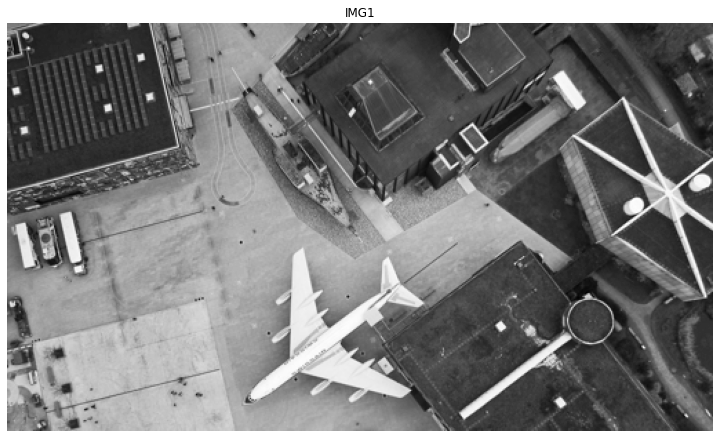

In [12]:
plotter(img1, "IMG1")

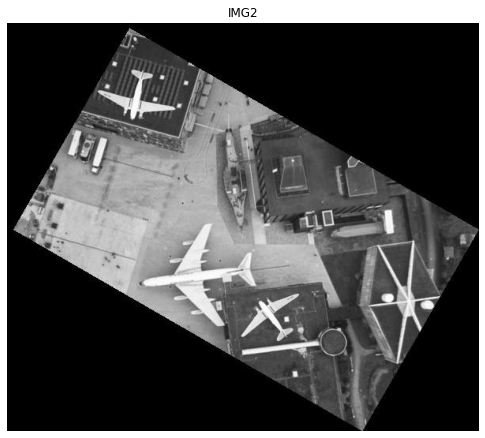

In [13]:
plotter(img2, "IMG2")

Let us look at the result on transforming IMG2

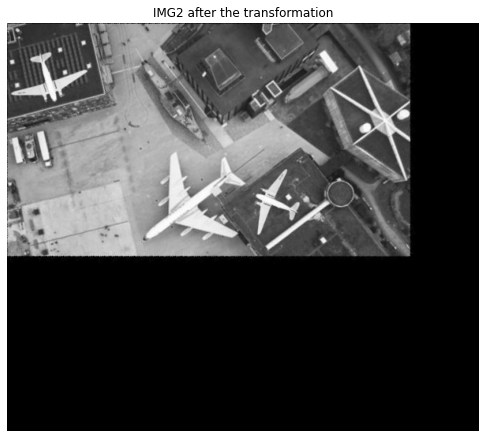

In [14]:
plotter(new_image, "IMG2 after the transformation")

Clearly there are empty pixels along the right and bottom borders. However, no useful information is lost in the transformation. We can crop it to be of the size of the original image by removing the black borders for easier comparision.

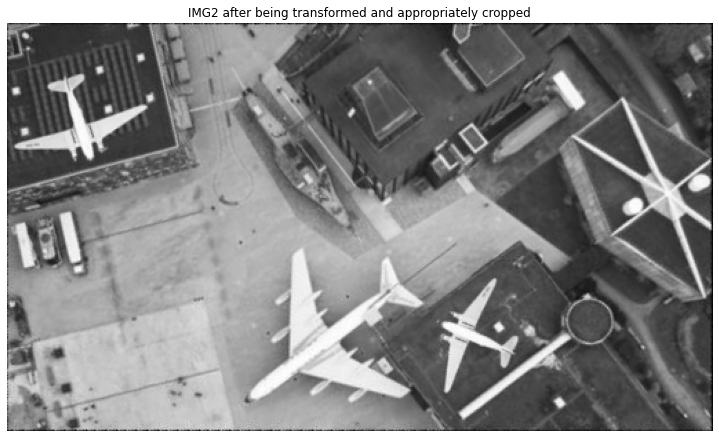

In [15]:
x1, y1 = np.shape(img1)
cropped = new_image[:x1, :y1]
plotter(cropped, "IMG2 after being transformed and appropriately cropped")

Let us look at the difference now

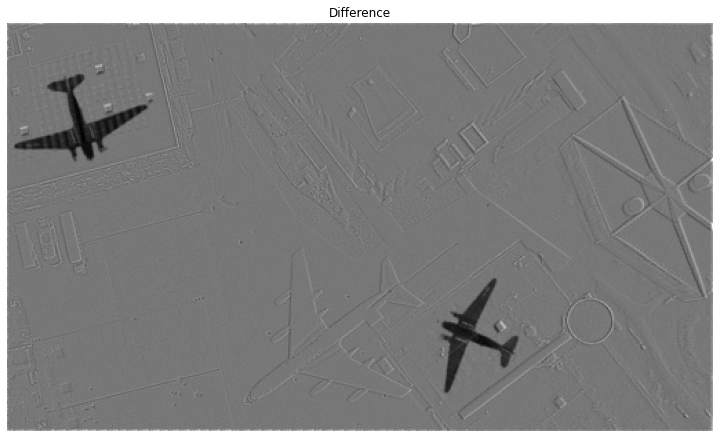

In [16]:
# To ensure we have positive values only
diff = (img1-cropped)+abs(np.min(img1-cropped))
# Normalizing the difference image to lie between 0 and 1 
diff = diff/np.max(diff)
plotter(diff, "Difference")

This is a very interesting result. Grey values correspond to no change. We can clearly detect the two aeroplanes which are missing in IMG2 in black. Apart from that, there is also a small amount of translation which is apparent from the embossed appearance of the difference image

#### What if we went the other way round, i.e., tried to transform IMG1 to get IMG2. The resulting image is shown.

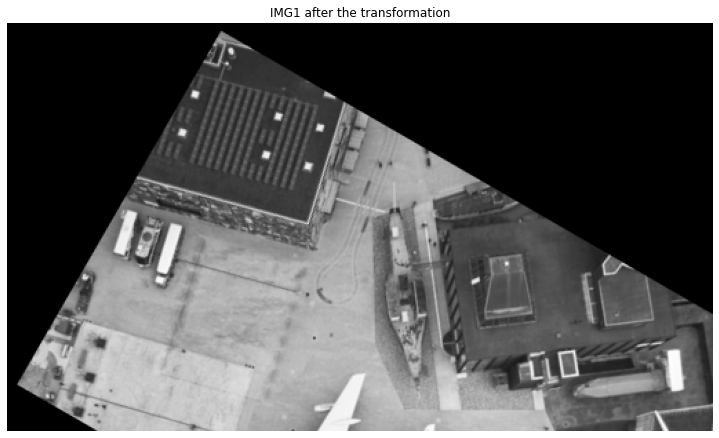

In [17]:
A_ = A_matrix(points, corresponding_points)
H_ = compute_homography(A_)
new_image_ = transform_image(img1, H_)
plotter(new_image_, "IMG1 after the transformation")

Clearly this is not desirable. We have lost a lot of useful information. Even if we take the difference, there is no way we can detect the two planes which have moved away from the scene as they are not present in the transformed IMG1.

# Observations
The following observations can be made
- What has changed in the scene is the disappearance of two planes. A simple image difference would never be able to detect that. Appropriate alignment using homography and then taking the difference gives a clear indication of the scene changes
- It is important to decide which of the two given images must be transformed and aligned for us to get useful information as we just saw in the previous section
- As the correspondance points given in this assignment were not noisy, the homography matrix we obtained does indeed correspond to one of in-plant translation and in-plane rotation